In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
import xgboost as xgb
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
energy_df = pd.read_csv('data/energy/AEP_hourly.csv', 
                        parse_dates=['Datetime'], 
                        index_col='Datetime')
energy_df = energy_df.sort_index()
energy_df.head()

,AEP_MW
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0


In [3]:
print("NULL Values:")
print(energy_df.isnull().sum())

NULL Values:
AEP_MW    0
dtype: int64


In [4]:
energy_df.describe()

,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


In [5]:
print("Earliest Date:", energy_df.index.min())
print("Latest Date:", energy_df.index.max())

Earliest Date: 2004-10-01 01:00:00
Latest Date: 2018-08-03 00:00:00


In [6]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['day_of_year'] = df.index.dayofyear
    df['day_of_month'] = df.index.day
    df['week'] = df.index.isocalendar().week
    return df

In [7]:
df = create_features(energy_df)

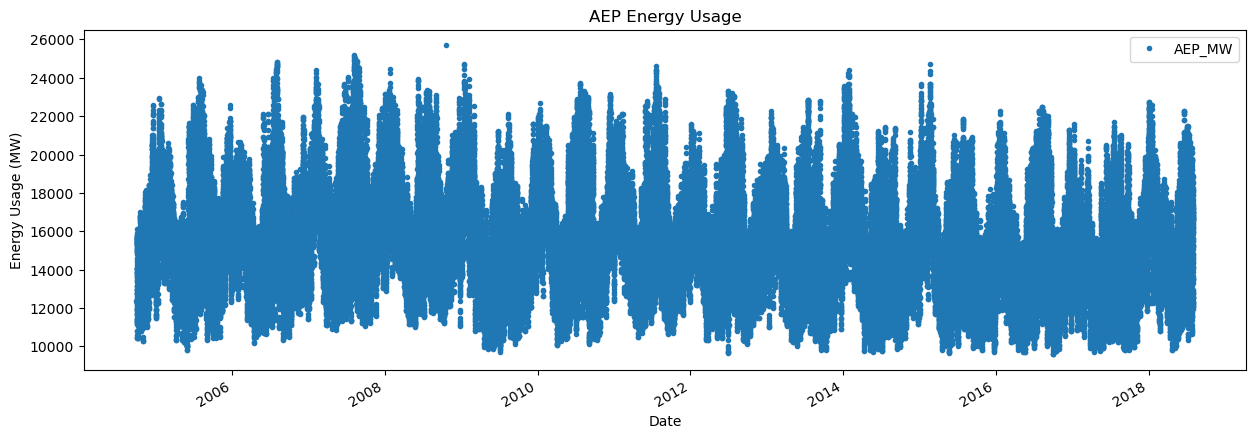

In [8]:
df.plot(y='AEP_MW',
        figsize=(15,5),
        title="AEP Energy Usage",
        style='.')
plt.ylabel('Energy Usage (MW)')
plt.xlabel('Date')
plt.show()

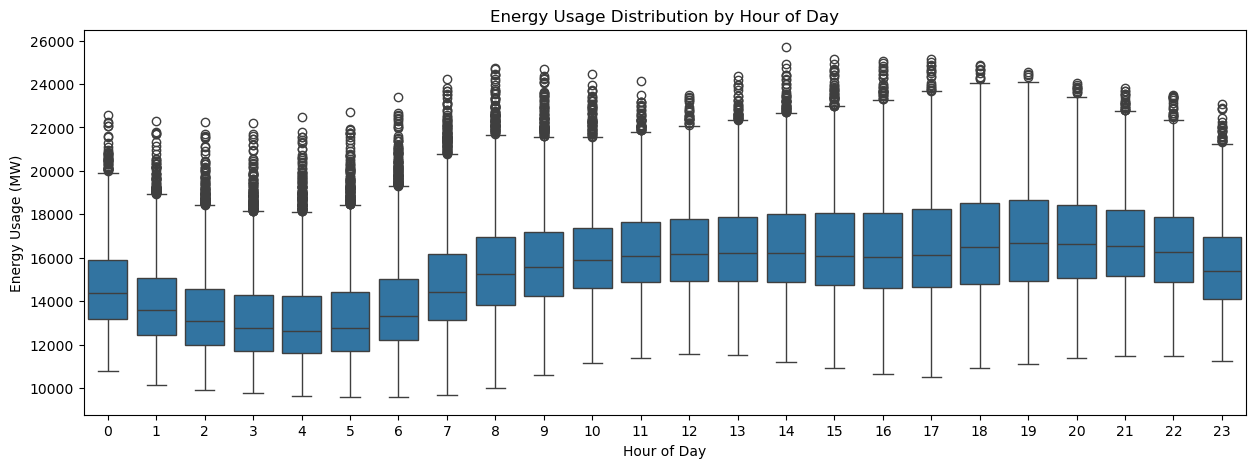

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x=df['hour'], y=df['AEP_MW'], ax=ax)
plt.title("Energy Usage Distribution by Hour of Day")
plt.ylabel('Energy Usage (MW)')
plt.xlabel('Hour of Day')
plt.show()

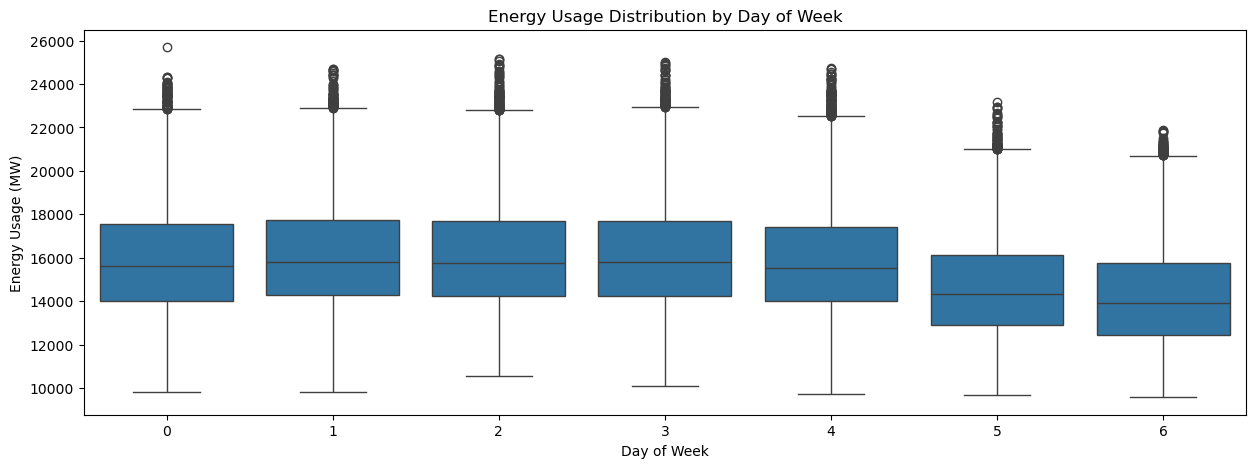

In [10]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x=df['day_of_week'], y=df['AEP_MW'], ax=ax)
plt.title("Energy Usage Distribution by Day of Week")
plt.ylabel('Energy Usage (MW)')
plt.xlabel('Day of Week')
plt.show()

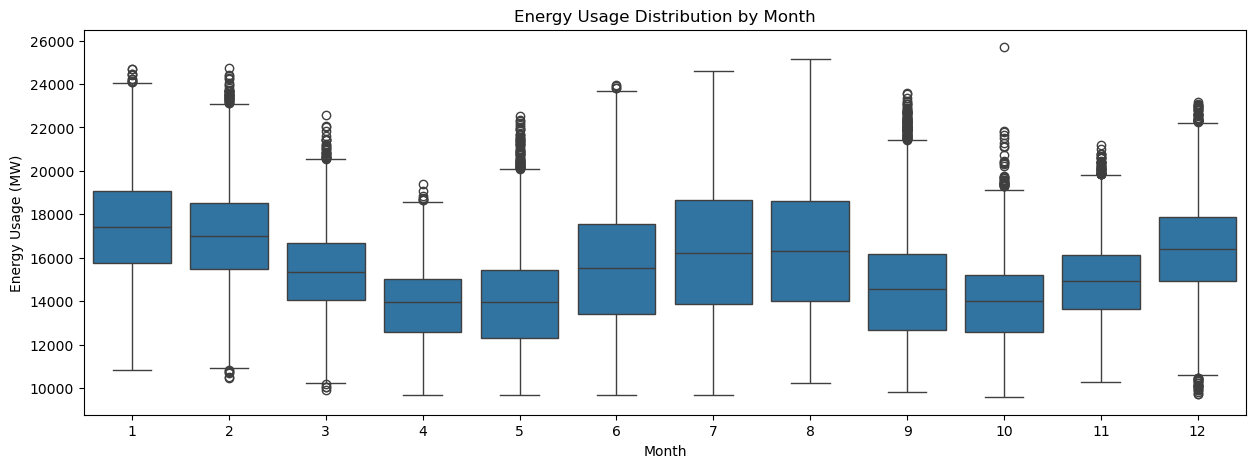

In [11]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x=df['month'], y=df['AEP_MW'], ax=ax)
plt.title("Energy Usage Distribution by Month")
plt.ylabel('Energy Usage (MW)')
plt.xlabel('Month')
plt.show()

In [25]:
def stationary_check(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Value ({}): {:.3f}'.format(key, value))
    if result[1] <= 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is non-stationary.")

In [26]:
stationary_check(df['AEP_MW'])

ADF Statistic: -18.27295340085996
p-value: 2.3173985407245266e-30
Critical Value (1%): -3.430
Critical Value (5%): -2.862
Critical Value (10%): -2.567
The time series is stationary.


In [12]:
# Split the data into training and testing sets (80% train:20% test)
train, test = train_test_split(df, test_size=0.2, shuffle=False)
print(f"Training set range: {train.index.min()} -> {train.index.max()}")
print(f"Testing set range: {test.index.min()} -> {test.index.max()}")

# Divide the train/test sets into features(X) and target(y)
X_train = train.drop('AEP_MW', axis=1)
y_train = train['AEP_MW']
X_test = test.drop('AEP_MW', axis=1)
y_test = test['AEP_MW']

Training set range: 2004-10-01 01:00:00 -> 2015-10-27 09:00:00
Testing set range: 2015-10-27 10:00:00 -> 2018-08-03 00:00:00


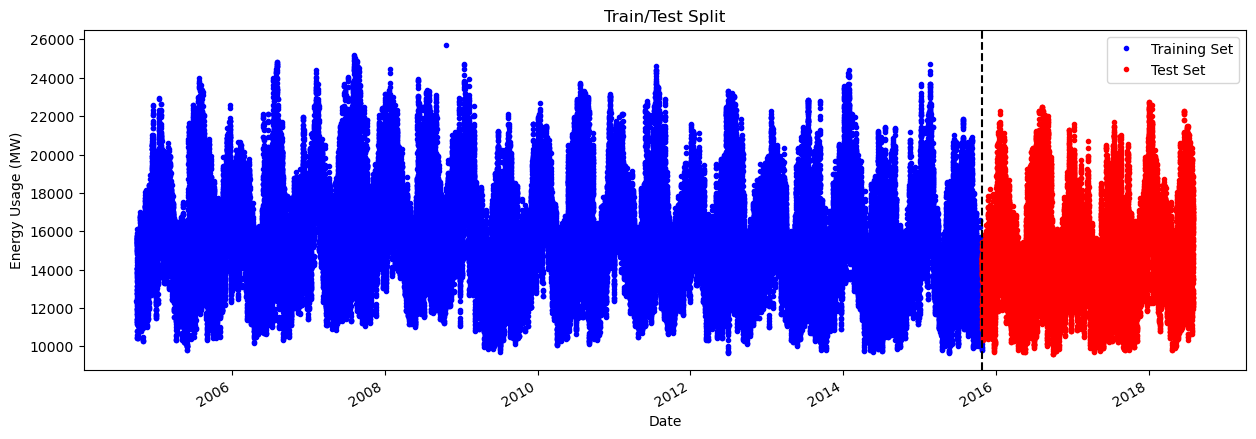

In [13]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(y='AEP_MW', ax=ax, label='Train Set', style='.', color='blue')
test.plot(y='AEP_MW', ax=ax, label='Test Set', style='.', color='red')
plt.title("Train/Test Split")
plt.ylabel('Energy Usage (MW)')
plt.xlabel('Date')
plt.legend(['Training Set', 'Test Set'])
plt.axvline(x=test.index.min(), color='black', linestyle='--' , label='Train/Test Split')
plt.show()

In [14]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=1000, 
                             early_stopping_rounds=None, 
                             learning_rate=0.01,
                             random_state=11)

xgb_param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_child_weight': [1, 5, 10]
}

tscv = TimeSeriesSplit(
    n_splits=5,
    gap=7
)

xgb_grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv,
    n_jobs=-1,
    verbose=2
)

xgb_grid_search.fit(X_train, y_train)

print(f"Best Parameters: {xgb_grid_search.best_params_}")
print(f"Best Score: {xgb_grid_search.best_score_}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 500}
Best Score: -2573531.265170532


In [15]:
best_xgb_model = xgb_grid_search.best_estimator_
y_pred = best_xgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"XGB Test Set RMSE: {rmse:.4f}")

XGB Test Set RMSE: 1699.4110


In [16]:
test['prediction'] = y_pred
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

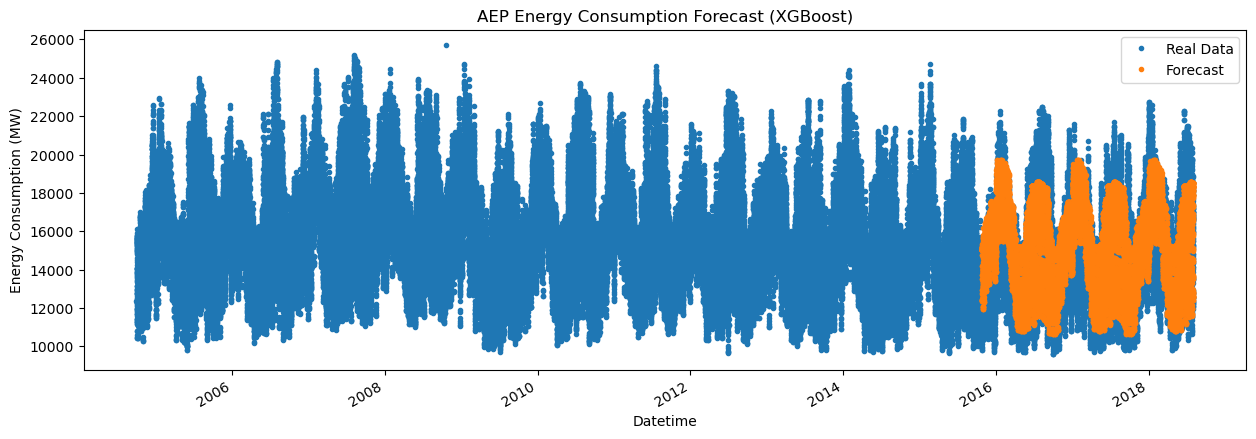

In [17]:
ax = df[['AEP_MW']].plot(figsize=(15,5),
                         style='.')
df['prediction'].plot(ax=ax, style='.')
ax.set_title('AEP Energy Consumption Forecast (XGBoost)')
ax.set_ylabel('Energy Consumption (MW)')
plt.legend(['Real Data','Forecast'])
plt.show()

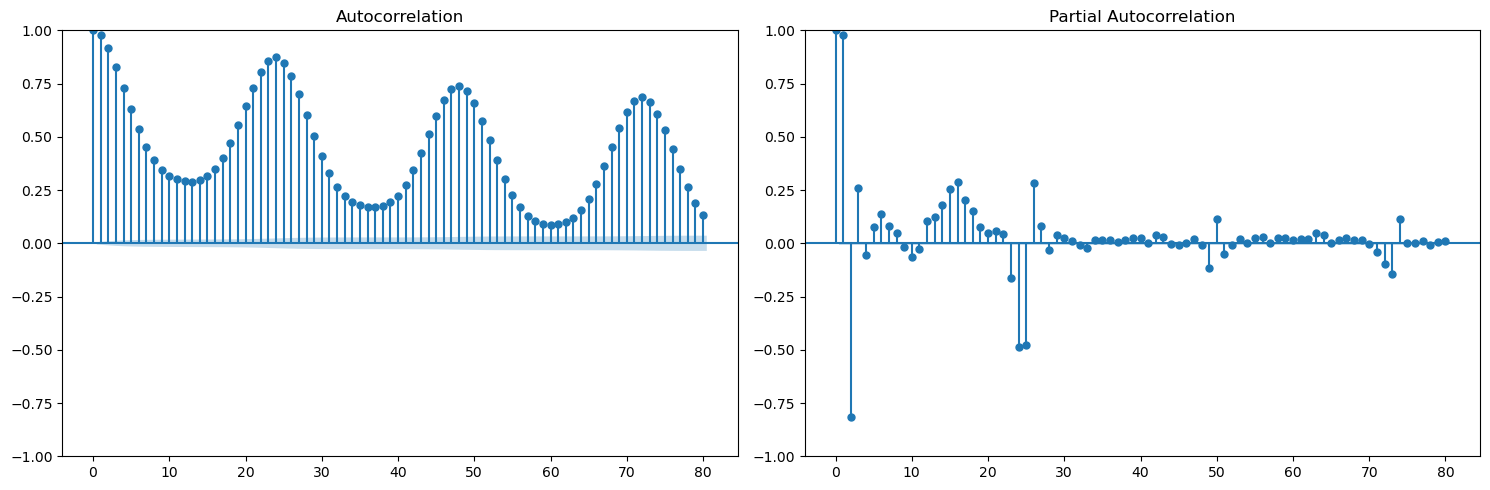

In [34]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))
plot_acf(df['AEP_MW'], lags=80, ax=ax[0])
plot_pacf(df['AEP_MW'], lags=80, ax=ax[1])
plt.tight_layout()
plt.show()

In [35]:
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12

model = SARIMAX(train['AEP_MW'],
                order=(p, d, q),
                seasonal_order=(P, D, Q, s))
sarimax_result = model.fit(disp=False)
print(sarimax_result.summary())

c:\Users\Daelin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Daelin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Daelin\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Daelin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse
c:\Users\Daelin\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1431: RuntimeWarnin

                                     SARIMAX Results                                      
Dep. Variable:                             AEP_MW   No. Observations:                97018
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                   0.000
Date:                            Tue, 02 Dec 2025   AIC                             10.000
Time:                                    20:10:18   BIC                             57.413
Sample:                                         0   HQIC                            24.408
                                          - 97018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000         -0       -inf      0.000       1.000       1.000
ma.L1         -1.0000         -0   

c:\Users\Daelin\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
